In [398]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from data.data import InvERTDataset
from model.models import UNet
from json5 import load as json_load
import cv2

In [399]:
with open("/mnt/ensg/tout_le_monde/Basile/PEGGHy/PEGGHy_20mars2025.Dat", "r", encoding='utf8') as datafile:
    lines = datafile.readlines()

In [400]:
datalines = lines[9:-4]
print(datalines[0].strip())
print(datalines[-1].strip())

num_electrodes = 48

4  0.00  0.00 3.00  0.00 1.00  0.00 2.00  0.00 19.07
4  44.00  0.00 47.00  0.00 45.00  0.00 46.00  0.00 324.33


In [401]:
a = int(0.00)

In [402]:
pseudosection = np.zeros((48 // 2 - 1, 48 - 3))
rho_apps = []
for i, line in enumerate(datalines):
    line = line.strip().split()
    A, B, M, N = int(float(line[1])), int(float(line[3])), int(float(line[5])), int(float(line[7]))
    rhoapp = float(line[9])
    row = (B - A) // 2 - 1
    col = M - 1
    if np.random.random() < 0.0:
        pseudosection[row, col] = 1
    else:
        pseudosection[row, col] = rhoapp
    rho_apps.append(rhoapp)

mean_rhoapp = np.mean(rho_apps)
for i in range(48 // 2 - 1):
    for j in range(i, 48 - 3 - i):
        if pseudosection[i, j] == 0:
            # pseudosection[i, j] = 1
            pseudosection[i, j] = pseudosection[i - 1, j]

pseudosection[pseudosection == 0] = np.nan

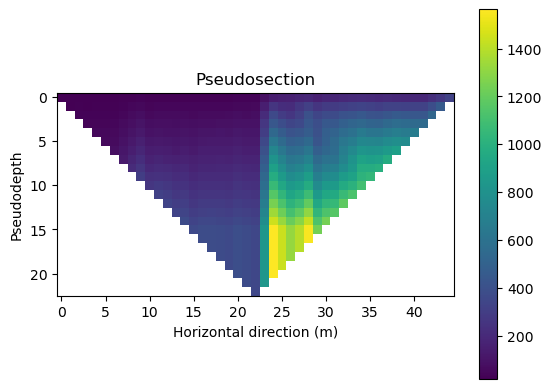

In [403]:
plt.imshow(pseudosection, cmap="viridis")
plt.colorbar()
plt.title("Pseudosection")
plt.xlabel("Horizontal direction (m)")
plt.ylabel("Pseudodepth")
plt.show()

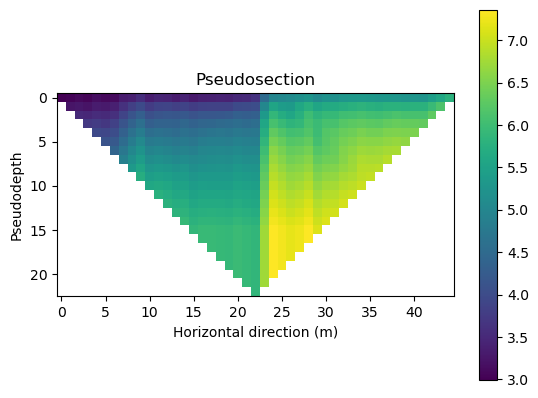

In [404]:
pseudosection = np.log1p(pseudosection)
plt.imshow(pseudosection, cmap="viridis")
plt.colorbar()
plt.title("Pseudosection")
plt.xlabel("Horizontal direction (m)")
plt.ylabel("Pseudodepth")
plt.show()

In [405]:
with open("/mnt/ensg/tout_le_monde/Basile/dataset_sensitivity_5_5_cosine_tape/overall_statistics.txt", "r", encoding='utf8') as minmaxfile:
    lines = minmaxfile.readlines()
min_dataset = float(eval(lines[-1].strip().split()[3].strip(',')))
max_dataset = float(eval(lines[-1].strip().split()[5].strip('}')))
print(min_dataset)
print(max_dataset)

0.0
10.673124313354492


In [406]:

px_to_m = 1

num_electrodes = 48
true_survey_length_m = num_electrodes - 1

inter_electrode_distance = 5
total_padding = inter_electrode_distance * 5 * 2
W = (num_electrodes - 1) * inter_electrode_distance + total_padding
print(f"Width of the survey: {W} pixels")

L_t = true_survey_length_m / (W - total_padding)
print(f"PX to m: {L_t}")

W_m = W * L_t
print(f"Width of the survey: {W_m} m")

subsection_length = W_m

Width of the survey: 285 pixels
PX to m: 0.2
Width of the survey: 57.0 m


Width of the survey: 0.1875 normalized


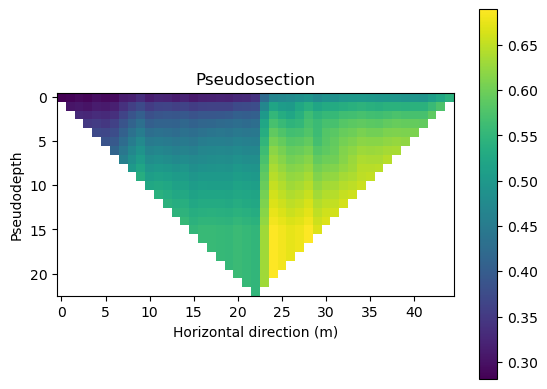

In [407]:
pseudosection = pseudosection - min_dataset
pseudosection = pseudosection / (max_dataset - min_dataset)

num_electrodes = (48 - 24) / (96 - 24)
subsection_length = (subsection_length - 24) / (200 - 24)
print(f"Width of the survey: {subsection_length} normalized")

plt.imshow(pseudosection, cmap="viridis")
plt.colorbar()
plt.title("Pseudosection")
plt.xlabel("Horizontal direction (m)")
plt.ylabel("Pseudodepth")
plt.show()

pseudosection[np.isnan(pseudosection)] = 0

In [408]:
# pseudosection = cv2.resize(pseudosection, (93, 49), interpolation=cv2.INTER_LINEAR)
# pseudosection[np.isnan(pseudosection)] = 0
# plt.imshow(pseudosection, cmap="viridis")
# plt.colorbar()
# plt.title("Pseudosection")
# plt.xlabel("Horizontal direction (m)")
# plt.ylabel("Pseudodepth")
# plt.show()

In [409]:
experiment_path = Path("/home/labo3A/results/no_pad_no_resize_sum_weight_05-05-2025_15h46")
# experiment_path = Path("/mnt/ensg/tout_le_monde/Basile/results/resized_features_25-04-2025_11h28")

model_ckpt_path = experiment_path / "figures/model_output/checkpoints"
model_ckpt_list = sorted(model_ckpt_path.glob("*.pth"), key=lambda x: int(x.stem.split("_")[-1]))
print(f"Found {len(model_ckpt_list)} checkpoints, last one is {model_ckpt_list[-1].stem}")
model = UNet()
model.load_state_dict(torch.load(model_ckpt_list[-1], map_location='cpu')['model_state_dict'])
model.eval()

Found 15 checkpoints, last one is model_epoch_15


UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): InstanceNor

In [410]:
true_pseudosection = torch.from_numpy(pseudosection.astype(np.float32))
print(true_pseudosection)
print(true_pseudosection.shape)

true_pseudosection = true_pseudosection.unsqueeze(0)
num_electrode_channel = torch.ones_like(true_pseudosection) * num_electrodes
subsection_length_channel = torch.ones_like(true_pseudosection) * subsection_length
wa_array_type_channel = torch.zeros_like(true_pseudosection)
slm_array_type_channel = torch.ones_like(true_pseudosection)
true_pseudosection = torch.cat((true_pseudosection, num_electrode_channel, subsection_length_channel, wa_array_type_channel, slm_array_type_channel), dim=0)
# norm_log_resistivity_model = torch.zeros((192, 256))
norm_log_resistivity_model = torch.zeros((213, 285))

true_pseudosection = true_pseudosection.unsqueeze(0)
norm_log_resistivity_model = norm_log_resistivity_model.unsqueeze(0).unsqueeze(0)

print(true_pseudosection.shape)
print(norm_log_resistivity_model.shape)


tensor([[0.2810, 0.2856, 0.2920,  ..., 0.5097, 0.5244, 0.5420],
        [0.0000, 0.3041, 0.3066,  ..., 0.5576, 0.5744, 0.0000],
        [0.0000, 0.0000, 0.3291,  ..., 0.5881, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
torch.Size([23, 45])
torch.Size([1, 5, 23, 45])
torch.Size([1, 1, 213, 285])


In [411]:
output = model(true_pseudosection, norm_log_resistivity_model)

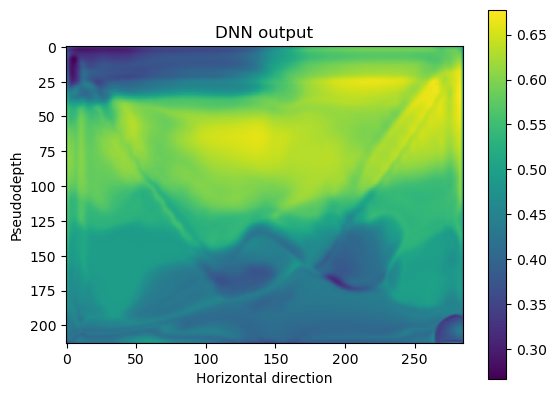

In [412]:
plt.imshow(output[0, 0].detach().numpy(), cmap="viridis")
plt.colorbar()
plt.title("DNN output")
plt.xlabel("Horizontal direction")
plt.ylabel("Pseudodepth")
plt.show()

In [413]:
num_e = int(num_electrodes * (96 - 24) + 24)

inter_electrode_distance = 5
inter_electrode_distance_m = 1
total_padding = 2 * 5 * inter_electrode_distance
W = int((num_e - 1) * inter_electrode_distance + total_padding)

true_sruvey_l = (num_e - 1) * inter_electrode_distance_m

print(f"Width of the resistivity model: {W} pixels")

px_to_m = true_sruvey_l / (W - total_padding)
print(f"Pixel to meter ratio: {px_to_m} m/pixel")

W_m = int(W * px_to_m)
print(f"Width of the resistivity model in meters: {W_m} m")

normalized_subsection_length = (W_m - 24) / (200 - 24)
print(f"Normalized subsection length: {normalized_subsection_length}")

Width of the resistivity model: 285 pixels
Pixel to meter ratio: 0.2 m/pixel
Width of the resistivity model in meters: 57 m
Normalized subsection length: 0.1875


213
Horizontal length in meters: 57 m
[ 25  30  35  40  45  50  55  60  65  70  75  80  85  90  95 100 105 110
 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200
 205 210 215 220 225 230 235 240 245 250 255 260]


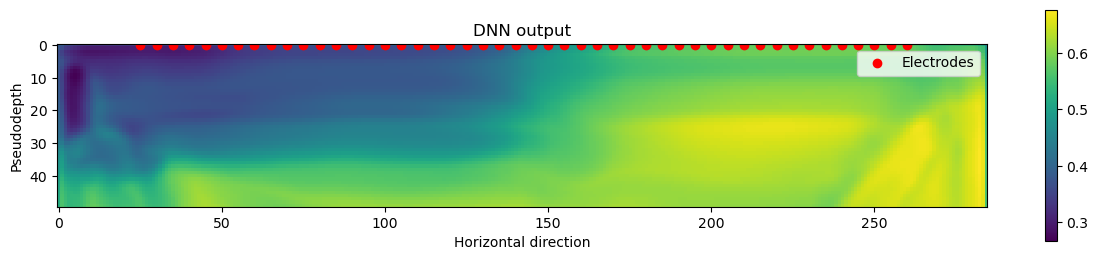

In [414]:
output_np = output[0, 0].detach().numpy()
# true_dims = cv2.resize(output_np, (255, 191), interpolation=cv2.INTER_LINEAR)
output_to_show = output_np[:]
print(len(output_to_show))
horizontal_length_m = 1 * W_m
print(f"Horizontal length in meters: {horizontal_length_m} m")
vertical_length_m = int(horizontal_length_m * 0.75)

depth = 10
depth_to_pixel = int(depth * output_np.shape[0] / vertical_length_m)

x_elec = np.arange(25, W - 25 + 1, 5)
print(x_elec)
y_elec = [0 for _ in range(len(x_elec))]
plt.figure(figsize=(15, 3))
plt.scatter(x_elec, y_elec, c="red", marker="o", label="Electrodes")
plt.imshow(output_to_show[:depth_to_pixel], cmap="viridis")
plt.colorbar()
plt.title("DNN output")
plt.xlabel("Horizontal direction")
plt.ylabel("Pseudodepth")
plt.legend()
plt.show()

In [415]:
def detransform(log_res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return np.exp(log_res * np.log(50000)).astype(log_res.dtype)

o = detransform(output_to_show[:depth_to_pixel])

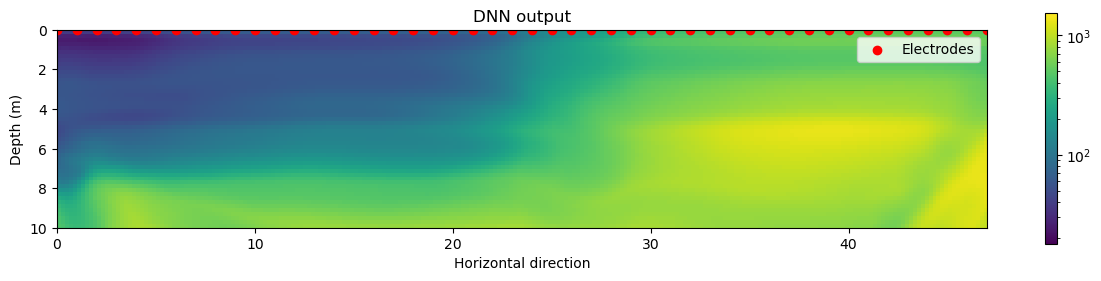

1529.5625
17.88219


In [416]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(15, 3))
max_v = np.max(o)
min_v = np.min(o)
norm = LogNorm(vmin=min_v, vmax=max_v)
extent = [0, 47, depth, 0]

x_elec_ = (x_elec - 25) * px_to_m
plt.scatter(x_elec_, y_elec, c="red", marker="o", label="Electrodes")
plt.imshow(o[:, 25:W-25], cmap="viridis", extent=extent, norm=norm)
plt.colorbar()
plt.title("DNN output")
plt.xlabel("Horizontal direction")
plt.ylabel("Depth (m)")
plt.legend()
plt.show()
print(max_v)
print(min_v)